## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Global Variables

In [2]:
raw_data = "../../../Lead_Data/"
lead_time = "100"

## Reading CSV

In [3]:
## Read in Raw Data
S1 = pd.read_csv(raw_data + lead_time + "_1.csv") # 1601594
S2 = pd.read_csv(raw_data + lead_time + "_2.csv") # 1462598
S3 = pd.read_csv(raw_data + lead_time + "_3.csv") # 1048576
C1 = pd.read_csv(raw_data + lead_time + "_4.csv") # 1395756
C2 = pd.read_csv(raw_data + lead_time + "_5.csv") # 928948
C3 = pd.read_csv(raw_data + lead_time + "_6.csv") # 949888

## Remove outliers 

In [4]:
# removing one second radius of window which look like a fall 
# at 801934 msec in C3 subject 
# and at 1268349 msec in S2 subject
S2.drop(S2.loc[(S2.time_counter >= 1267349) & (S2.time_counter <= 1269349)].index, inplace = True)
C3.drop(C3.loc[(C3.time_counter >= 800934) & (C3.time_counter <= 802934)].index, inplace = True)


In [5]:
C3.loc[(C3.time_counter >= 801824) & (S2.time_counter <= 801840)]

,time_counter,accel_base_X,fall_value,accel_base_Y,accel_base_Z,accel_base_mag


## Convert Data to Numpy Arrays

In [6]:
X = []
X.append(S1[['accel_base_X', 'accel_base_Y', 'accel_base_Z','accel_base_mag']].values)
X.append(S2[['accel_base_X', 'accel_base_Y', 'accel_base_Z','accel_base_mag']].values)
X.append(S3[['accel_base_X', 'accel_base_Y', 'accel_base_Z','accel_base_mag']].values)
X.append(C1[['accel_base_X', 'accel_base_Y', 'accel_base_Z','accel_base_mag']].values)
X.append(C2[['accel_base_X', 'accel_base_Y', 'accel_base_Z','accel_base_mag']].values)

X_test = C3[['accel_base_X', 'accel_base_Y', 'accel_base_Z','accel_base_mag']].values
X = np.vstack(X) # Concatenate all the arrays

## Scale Data and Recombine

In [198]:
def featureScale(X_train, X_test): # Normalizes NP Array of Features
    sc = MinMaxScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test

In [199]:
X, X_test = featureScale(X, X_test)
X = np.vstack((X, X_test)) # Recombine after scaling train and test data with the same mean and variance

## Separate Data into Subjects after Scaling

In [7]:
start_idx = 0
end_idx = 0
lst = [S1,S2,S3,C1,C2,C3]
for sub in lst:
    end_idx += len(sub)
    sub['accel_base_X'] = X[start_idx:end_idx, 0] 
    sub['accel_base_Y'] = X[start_idx:end_idx, 1]
    sub['accel_base_Z'] = X[start_idx:end_idx, 2]
    sub['accel_base_mag'] = X[start_idx:end_idx, 3]
    start_idx = end_idx

ValueError: Length of values does not match length of index

## Extract Features to numpy file

In [8]:
def new_create_df(dataset, look_back, fall_buffer, features, rem_range, skip):

  fall_sec = dataset[dataset['fall_value']==1].index.values.tolist()
  dataset = dataset[features]
  print(dataset.head())
  data_df = pd.DataFrame(columns=['sec','X','Y'])
  feat_count = len(features) -1
  print('Fall_sec: ',fall_sec)
  sec = []
  A = []
  B = []
  end_list = []  #edge condition for non-fall values
  start_list = [0]
  #prepare window frame 
  for i in range(len(fall_sec)):
      end_list.append(fall_sec[i] - rem_range)
      start_list.append(fall_sec[i] + rem_range)
  end_list.append(dataset.shape[0]-look_back-1)  
  
  #add fall values
  fall_count = 0
  for i,fall in enumerate(fall_sec):
        for j in range(fall-fall_buffer,fall+1,skip):  
            print(j)
            a = dataset.iloc[j-look_back:j, :feat_count].values
            a = np.reshape(a,(look_back,1,feat_count)).tolist()
            b = 1
            sec.append(j)
            A.append(a)
            B.append(b)
            fall_count += 1
  print("Added total falls of ",str(fall_count))
  #add non-fall values
  track = 100000
  for start,end in zip(start_list,end_list):
      for i in range(start,end,skip):
        a = dataset.iloc[i:i+look_back, :feat_count].values
        a = np.reshape(a,(look_back,1,feat_count)).tolist()
        b = dataset.iloc[i + look_back, feat_count]
        sec.append(i)
        A.append(a)
        B.append(b)
        if(i>track):
          print('row claculating',i)
          track += 100000 
  data_df['sec'] = sec
  data_df['X'] = A
  data_df['Y'] = B
  data_df = data_df.sort_values(by=['sec'])
  data_df = data_df.reset_index(drop = True)
  val = data_df.values
  X = np.reshape(val[:,1].tolist(),(val.shape[0],look_back,feat_count))
  Y = np.reshape(val[:,2].tolist(),(val.shape[0],1))
  return data_df,X,Y

## Extract Features, Save to File

In [9]:
features = {
    'mag' : ['accel_base_mag','fall_value'],
    'XYZ' : ['accel_base_X','accel_base_Y','accel_base_Z','fall_value'],
    'XYZ_mag' : ['accel_base_X','accel_base_Y','accel_base_Z','accel_base_mag','fall_value']
}

In [16]:
feat = "../../../Features/Lead_Times/100ms/XYZ_mag/" # Where to output features

lead_time = 100 # Declared at the top
lb = 50
rem_range = 500
skip_val = 25
feat_type = "XYZ_mag"
fall_buffer = 0

meta = "_" + str(feat_type) + "_" + str(lead_time) + "ms_" + str(lb) + "lb_" + str(fall_buffer) + "fb"

subjects = [S1, S2, S3, C1, C2, C3]
subject_names = ["S1", "S2", "S3", "C1", "C2", "C3"]

In [191]:
%%time
for i in range(len(subjects)):
    print("Extracting for Subject:", subject_names[i])
    temp_df, temp_x, temp_y = new_create_df(subjects[i], lb, fall_buffer, features[feat_type], rem_range, skip_val)
    
    with open(feat + "X_" + subject_names[i] + meta + ".npy", "wb") as f:
        np.save(f, temp_x)
    
    with open(feat + "Y_" + subject_names[i] + meta + ".npy", "wb") as f:
        np.save(f, temp_y)
    

Extracting for Subject: S1
   accel_base_X  accel_base_Y  accel_base_Z  fall_value
0          1372          1441          -674         0.0
1          1403          1514          -695         0.0
2          1414          1555          -556         0.0
3          1460          1658          -588         0.0
4          1440          1660          -576         0.0
Fall_sec:  [341097, 361565, 386571, 406718, 422670, 457962, 470794, 483551, 504175, 516389, 589135, 610911, 623077, 654761, 671718, 684551, 699279, 869428, 882218, 898976, 918070, 986652, 998351, 1014093, 1029462]
341097
361565
386571
406718
422670
457962
470794
483551
504175
516389
589135
610911
623077
654761
671718
684551
699279
869428
882218
898976
918070
986652
998351
1014093
1029462
Added total falls of  25
row claculating 100025
row claculating 200025
row claculating 300025
row claculating 400021
row claculating 500001
row claculating 600010
row claculating 700004
row claculating 800004
row claculating 900001
row claculatin

KeyboardInterrupt: 

In [15]:
%%time
s1_df, s1x_ts, s1y_ts = new_create_df(subjects[0], lb, fall_buffer, features[feat_type], rem_range, skip_val)

   accel_base_X  accel_base_Y  accel_base_Z  accel_base_mag  fall_value
0        1372.0        1441.0        -674.0     2100.747724         0.0
1        1403.0        1514.0        -695.0     2177.987603         0.0
2        1414.0        1555.0        -556.0     2174.064626         0.0
3        1460.0        1658.0        -588.0     2286.111983         0.0
4        1440.0        1660.0        -576.0     2271.778158         0.0
Fall_sec:  [341097, 361565, 386571, 406718, 422670, 457962, 470794, 483551, 504175, 516389, 589135, 610911, 623077, 654761, 671718, 684551, 699279, 869428, 882218, 898976, 918070, 986652, 998351, 1014093, 1029462]
341097
361565
386571
406718
422670
457962
470794
483551
504175
516389
589135
610911
623077
654761
671718
684551
699279
869428
882218
898976
918070
986652
998351
1014093
1029462
Added total falls of  25
row claculating 100025
row claculating 200025
row claculating 300025
row claculating 400021
row claculating 500001
row claculating 600010
row claculatin

### Plot features

In [209]:
s1x_ts.shape

(63099, 50, 4)

Index: 0


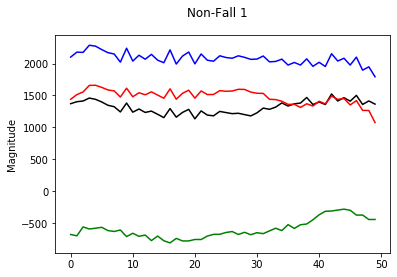

Index: 1


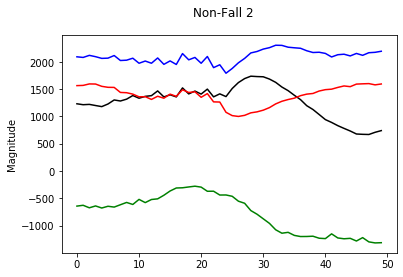

Index: 2


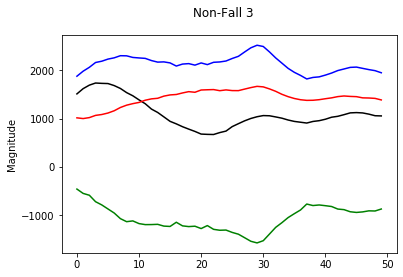

Index: 3


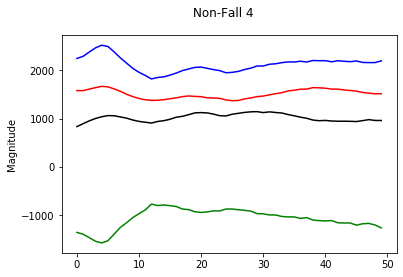

Index: 4


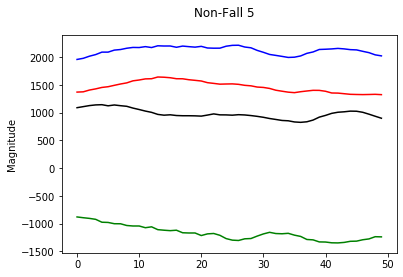

Index: 5


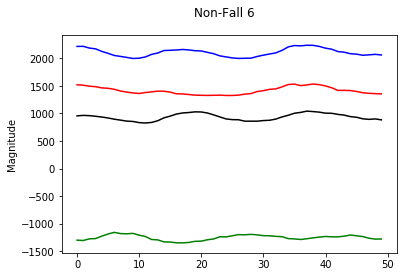

Index: 6


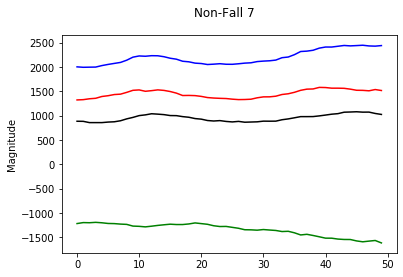

Index: 7


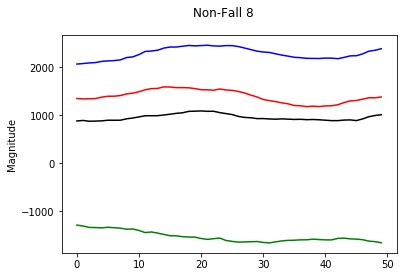

Index: 8


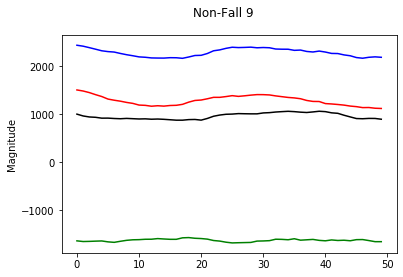

Index: 9


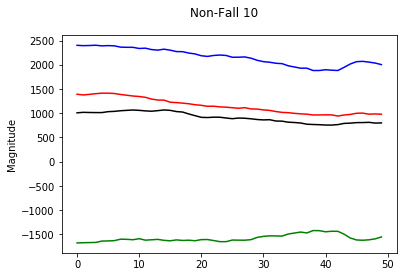

Index: 10


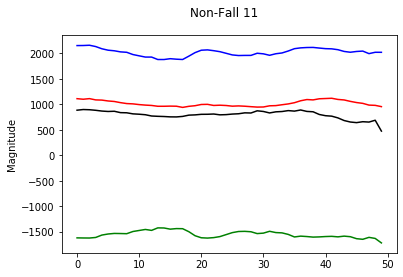

Index: 11


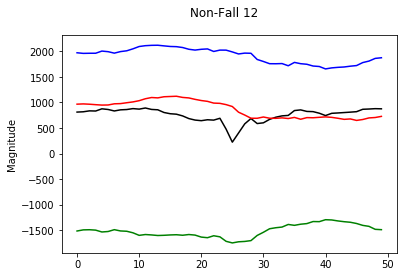

Index: 12


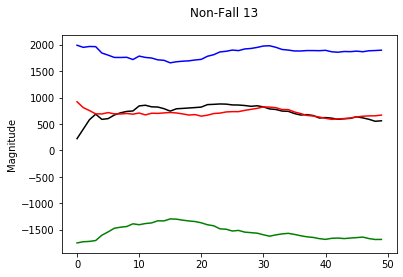

Index: 13


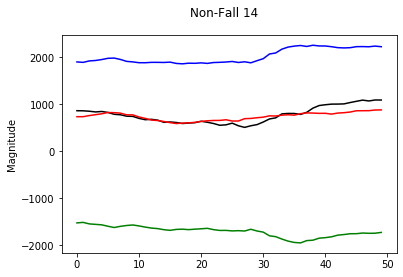

Index: 14


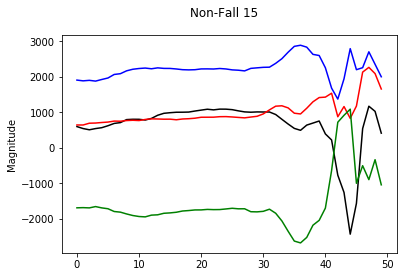

Index: 15


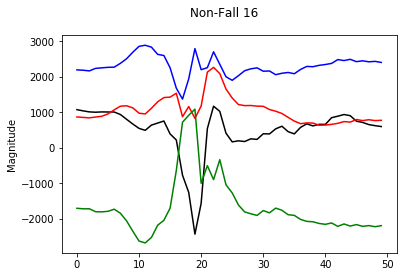

Index: 16


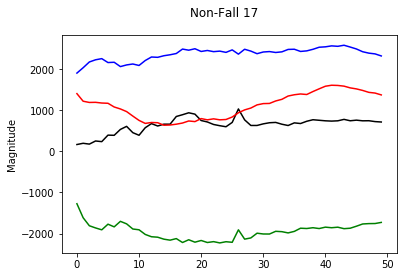

Index: 17


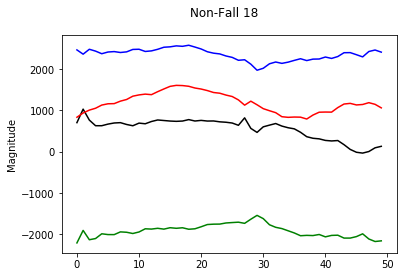

Index: 18


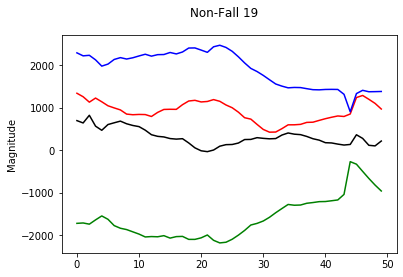

Index: 19


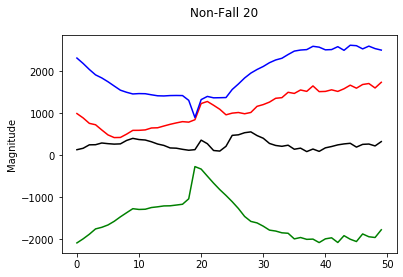

Index: 20


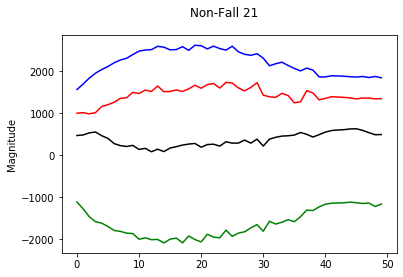

Index: 21


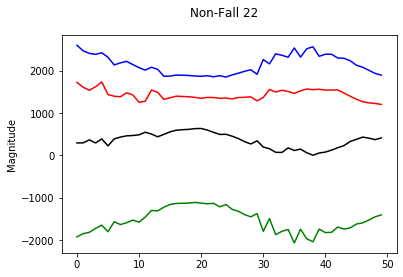

Index: 22


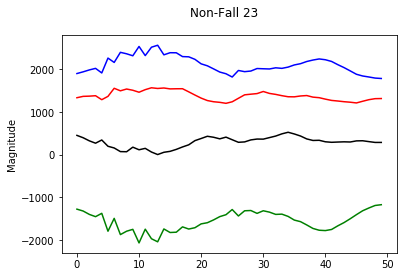

Index: 23


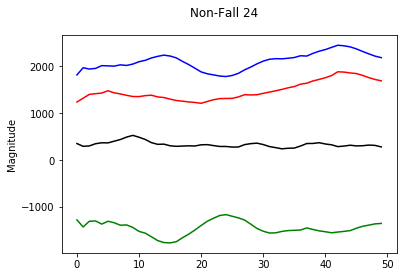

Index: 24


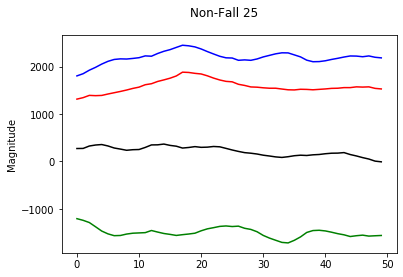

Index: 25


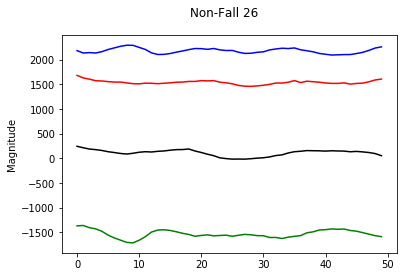

Index: 26


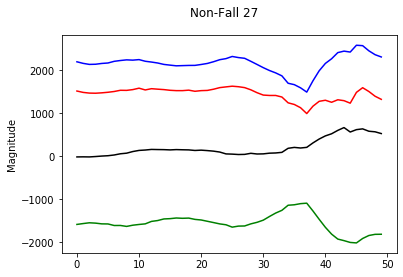

Index: 27


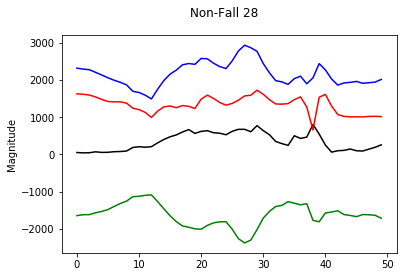

Index: 28


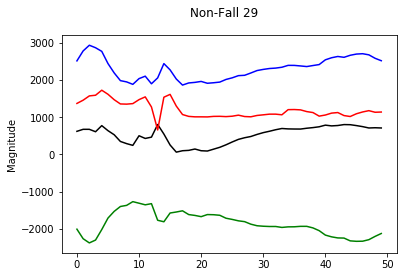

Index: 29


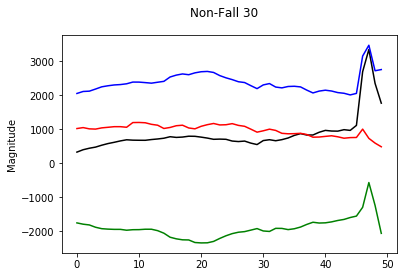

In [18]:
phase = 0
mod = 1
fall_count = 0
for i in (np.where(s1y_ts == 0)[0]):
    if (phase % mod == 0):
        fall_count += 1
    print("Index:", i)
    plt.ylabel("Magnitude")
    plt.suptitle("Non-Fall " + str(fall_count))
    plt.plot(s1x_ts[i][:, 0], color="black", label="Accel")
    plt.plot(s1x_ts[i][:, 1], color="red", label="X")
    plt.plot(s1x_ts[i][:, 2], color="green", label="Y")
    plt.plot(s1x_ts[i][:, 3], color="blue", label="Z")
    plt.show()
    phase += 1
    if (fall_count >= 30):
        break

Index: 13624


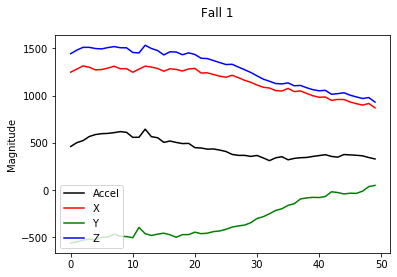

Index: 14404


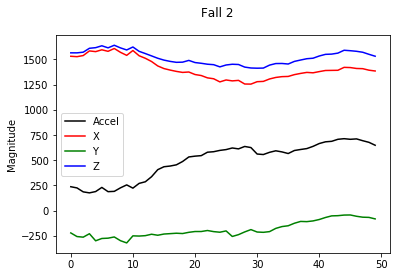

Index: 15366


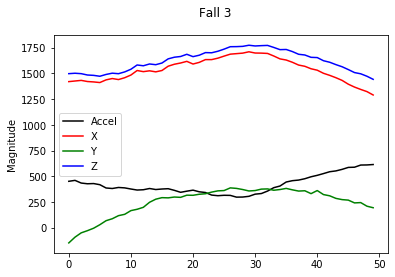

Index: 16133


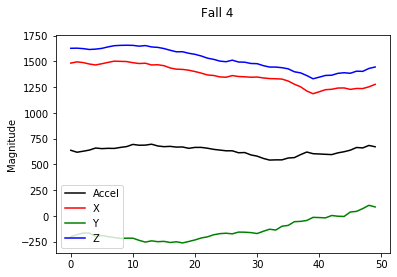

Index: 16733


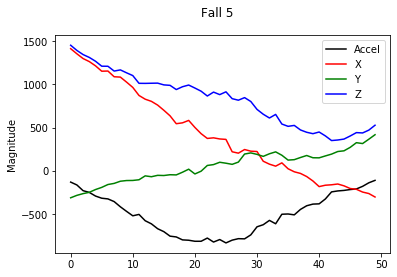

Index: 18106


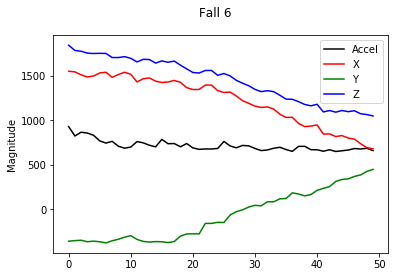

Index: 18581


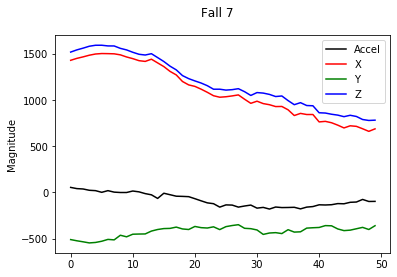

Index: 19053


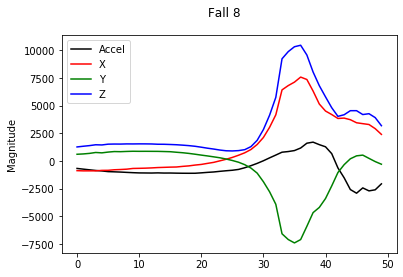

Index: 19839


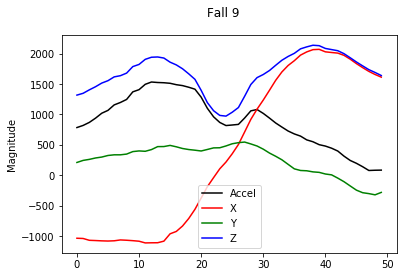

Index: 20289


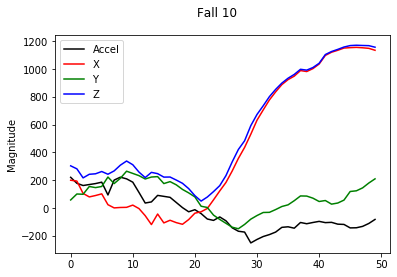

Index: 23160


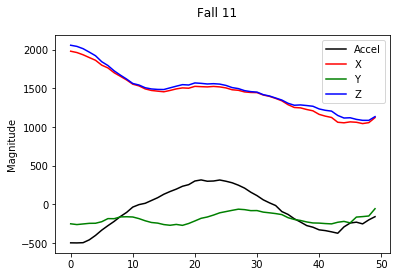

Index: 23993


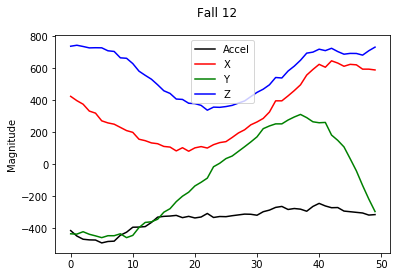

Index: 24441


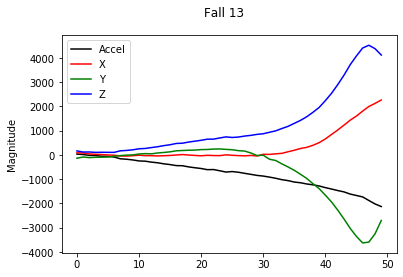

Index: 25670


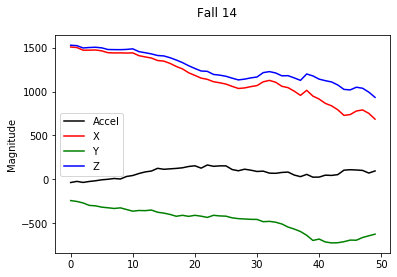

Index: 26310


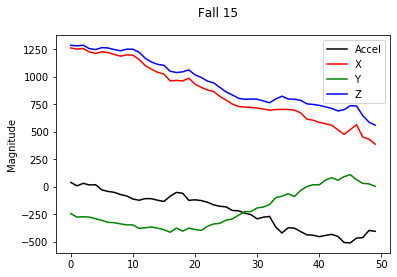

Index: 26785


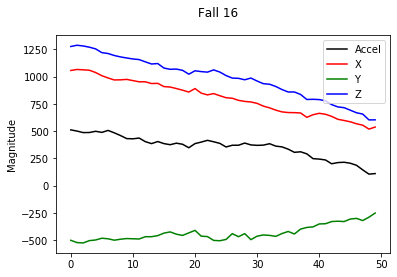

Index: 27336


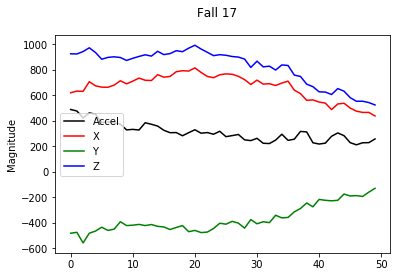

Index: 34103


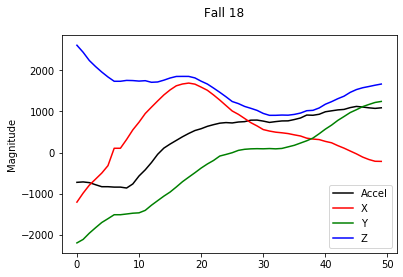

Index: 34576


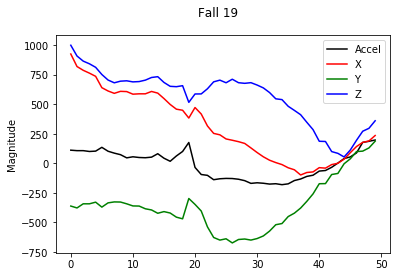

Index: 35208


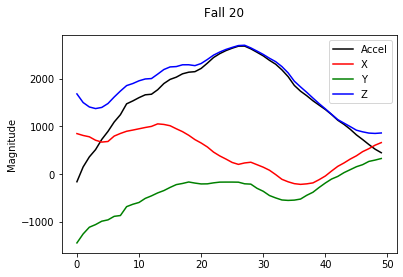

Index: 35933


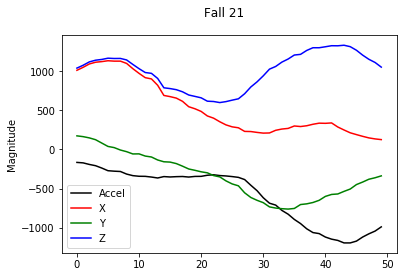

Index: 38638


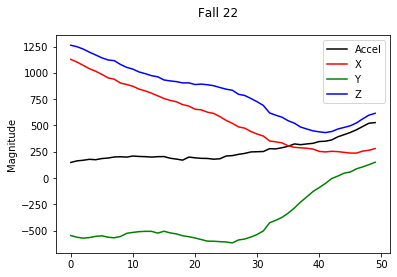

Index: 39067


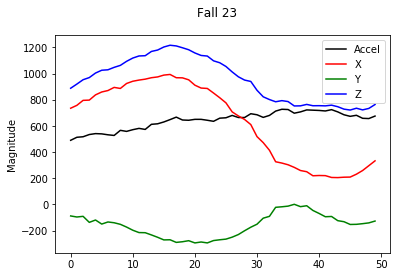

Index: 39658


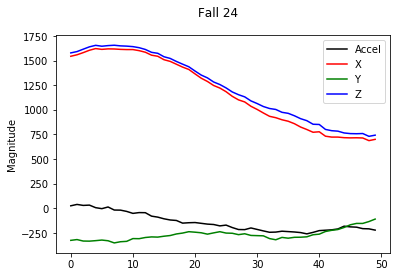

Index: 40234


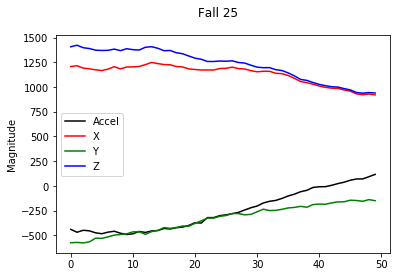

In [20]:
phase = 0
mod = 1
fall_count = 0
for i in (np.where(s1y_ts == 1)[0]):
    if (phase % mod == 0):
        fall_count += 1
    print("Index:", i)
    plt.ylabel("Magnitude")
    plt.suptitle("Fall " + str(fall_count))
    plt.plot(s1x_ts[i][:, 0], color="black", label="Accel")
    plt.plot(s1x_ts[i][:, 1], color="red", label="X")
    plt.plot(s1x_ts[i][:, 2], color="green", label="Y")
    plt.plot(s1x_ts[i][:, 3], color="blue", label="Z")
    plt.legend()
    plt.show()
    phase += 1

In [54]:
with open(feat + "X_S1" + meta +".npy", "wb") as f:
    np.save(f, s1x_ts)
    
with open(feat + "Y_S1" + meta +".npy", "wb") as f:
    np.save(f, s1y_ts)

## Do the same for the following

In [56]:
%%time
s2_df, s2x_ts, s2y_ts = new_create_df(S2, lb, features[feat_type], rem_range, skip_val)

with open(feat + "X_S2" + meta +".npy", "wb") as f:
    np.save(f, s2x_ts)
    
with open(feat + "Y_S2" + meta +".npy", "wb") as f:
    np.save(f, s2y_ts)

   accel_base_X  accel_base_Y  accel_base_Z  fall_value
0           -99          -121          2039         0.0
1           -35          -171          2089         0.0
2            52           -70          2075         0.0
3            -6           -81          2046         0.0
4           -15           -46          2008         0.0
Fall_sec:  [197531, 220400, 253249, 268599, 379558, 400434, 421863, 438577, 461088, 472141, 572101, 584686, 599396, 612767, 625093, 633922, 757458, 772017, 784448, 794470, 834265, 859689, 880099, 892101, 964684, 979748, 1001820, 1017211, 1058638, 1072405]
Added total falls of  30
row claculating 100025
row claculating 200006
row claculating 300024
row claculating 400934
row claculating 500016
row claculating 600021
row claculating 700022
row claculating 800020
row claculating 900001
row claculating 1000023
row claculating 1100005
row claculating 1200005
row claculating 1300005
row claculating 1400005
CPU times: user 24.7 s, sys: 916 ms, total: 25.6 s
Wall 

In [57]:
%%time
s3_df,s3x_ts, s3y_ts = new_create_df(S3, lb, features[feat_type], rem_range, skip_val)

with open(feat + "X_S3" + meta +".npy", "wb") as f:
    np.save(f, s3x_ts)
    
with open(feat + "Y_S3" + meta +".npy", "wb") as f:
    np.save(f, s3y_ts)

   accel_base_X  accel_base_Y  accel_base_Z  fall_value
0            18           271         -2114         0.0
1            37           273         -2110         0.0
2            -5           242         -2043         0.0
3            17           248         -2071         0.0
4           -14           345         -2094         0.0
Fall_sec:  [332603, 346739, 418686, 435007, 459195, 473483, 576029, 594605, 617425, 632654, 653583, 668509, 682760, 694673, 813922, 824075, 866531, 879710, 888897, 906114, 922600, 940941, 1032045, 1048150]
Added total falls of  24
row claculating 100025
row claculating 200025
row claculating 300025
row claculating 400014
row claculating 500008
row claculating 600005
row claculating 700023
row claculating 800023
row claculating 900022
row claculating 1000016
CPU times: user 17 s, sys: 667 ms, total: 17.7 s
Wall time: 17.7 s


In [59]:
%%time
c1_df, c1x_ts, c1y_ts = new_create_df(C1, lb, features[feat_type], rem_range, skip_val)

with open(feat + "X_C1" + meta +".npy", "wb") as f:
    np.save(f, c1x_ts)
    
with open(feat + "Y_C1" + meta +".npy", "wb") as f:
    np.save(f, c1y_ts)

   accel_base_X  accel_base_Y  accel_base_Z  fall_value
0          -810           204         -1934         0.0
1          -811           204         -1940         0.0
2          -826           192         -1923         0.0
3          -822           176         -1931         0.0
4          -831           154         -1960         0.0
Fall_sec:  [191517, 210042, 242337, 267074, 284942, 298835, 383287, 400936, 427912, 445043, 460709, 474754, 502905, 522758, 556495, 574443, 678167, 689743, 705021, 719363, 796781, 814226, 822053, 833958, 842991, 851854, 864474, 871887, 881461, 889972]
Added total falls of  30
row claculating 100025
row claculating 200017
row claculating 300010
row claculating 400012
row claculating 500004
row claculating 600018
row claculating 700018
row claculating 800006
row claculating 900022
row claculating 1000022
row claculating 1100022
row claculating 1200022
row claculating 1300022
CPU times: user 24.7 s, sys: 933 ms, total: 25.6 s
Wall time: 25.6 s


In [60]:
%%time
c2_df,c2x_ts, c2y_ts = new_create_df(C2, lb, features[feat_type], rem_range, skip_val)

with open(feat + "X_C2" + meta +".npy", "wb") as f:
    np.save(f, c2x_ts)
    
with open(feat + "Y_C2" + meta +".npy", "wb") as f:
    np.save(f, c2y_ts)

   accel_base_X  accel_base_Y  accel_base_Z  fall_value
0          -121           578         -2008         0.0
1          -113           580         -2024         0.0
2          -116           574         -2033         0.0
3          -117           574         -2027         0.0
4          -135           574         -2041         0.0
Fall_sec:  [133663, 150152, 170667, 183794, 194943, 204523, 218243, 228233, 241367, 250249, 304765, 313490, 323617, 332523, 364748, 373795, 382644, 393285, 402012, 410297, 427381, 436056, 445802, 456106, 514146, 523196, 532739, 543132, 561261, 570017]
Added total falls of  30
row claculating 100025
row claculating 200018
row claculating 300024
row claculating 400010
row claculating 500006
row claculating 600017
row claculating 700017
row claculating 800017
row claculating 900017
CPU times: user 15.4 s, sys: 746 ms, total: 16.2 s
Wall time: 16.4 s


In [62]:
%%time
c3_df, c3x_ts, c3y_ts = new_create_df(C3, lb, features[feat_type], rem_range, skip_val)

with open(feat + "X_C3" + meta +".npy", "wb") as f:
    np.save(f, c3x_ts)
    
with open(feat + "Y_C3" + meta +".npy", "wb") as f:
    np.save(f, c3y_ts)

   accel_base_X  accel_base_Y  accel_base_Z  fall_value
0          -109          -256          3064         0.0
1          -168          -165          3005         0.0
2          -160           -67          2910         0.0
3           -67           -22          2834         0.0
4             1            -4          2722         0.0
Fall_sec:  [136223, 149231, 156782, 171901, 182697, 190583, 206854, 215109, 224844, 233721, 288676, 298821, 319181, 329607, 347819, 357259, 369420, 378479, 390313, 400704, 430953, 446188, 454732, 465657, 474518, 518231, 527288, 537195, 547189, 560526, 569524]
Added total falls of  31
row claculating 100025
row claculating 200008
row claculating 300021
row claculating 400013
row claculating 500018
row claculating 600024
row claculating 700024
row claculating 800024
row claculating 900024
CPU times: user 18 s, sys: 863 ms, total: 18.8 s
Wall time: 19 s
